# Test 2 - Comparaison avec une solution de référence 

**Idée :** On se place ici dans le cas du cercle avec levelset analytique.

On cherche à comparer les cas suivants :

- On compare le PINNs avec la solution exacte
- On compare le PINNs avec une solution sur-raffinée obtenue par FEM

(Dans les 2 cas on construira le maillage du cercle de manière classique)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import dolfin as df
import mshr

from laplacian2D_sdf_pinns import *
from scimba.equations.domain import SpaceTensor
# from article 

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU
torch loaded; device is cuda


## Load PINNs + Maillage

In [3]:
form = Circle2()
xdomain = domain.SpaceDomain(2, domain.SignedDistanceBasedDomain(2, form.bounds, form))
pde = Poisson_2D(xdomain,form)
u_theta = test_sdf(form)

0.3535533905932738
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/Article1/notebook/2_reference_solution/networks/test.pth
jsbdbshd
network loaded


In [4]:
def generate_mesh(nb_vert = 32):
    domain = mshr.Circle(df.Point(form.x0,form.y0), form.r)
                
    domain_O = form.bounds
    mesh_macro = df.RectangleMesh(df.Point(domain_O[0][0], domain_O[1][0]), df.Point(domain_O[0][1], domain_O[1][1]), nb_vert - 1, nb_vert - 1)
    h_macro = mesh_macro.hmax()
    H = int(nb_vert/3)
    mesh = mshr.generate_mesh(domain,H)
    h = mesh.hmax()
    while h > h_macro:
        H += 1
        mesh = mshr.generate_mesh(domain,H)
        h = mesh.hmax()
        
    return mesh
        
nb_vert = 32

std_mesh = generate_mesh(nb_vert)
V = df.FunctionSpace(std_mesh, 'CG', 1)
dx = df.Measure('dx', domain=std_mesh)

ref_mesh = generate_mesh(200)
V_ref = df.FunctionSpace(ref_mesh, 'CG', 1)
dx_ref = df.Measure('dx', domain=ref_mesh)

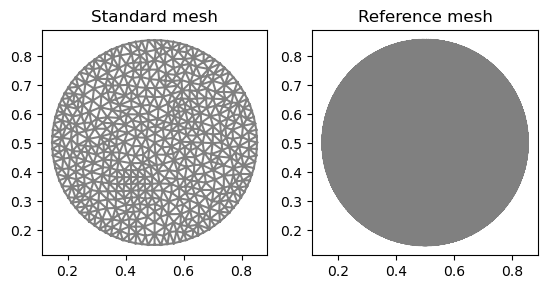

In [5]:
plt.figure()

plt.subplot(1,2,1)
df.plot(std_mesh)
plt.title('Standard mesh')

plt.subplot(1,2,2)
df.plot(ref_mesh)
plt.title('Reference mesh')

plt.show()

In [6]:
XXYY = V_ref.tabulate_dof_coordinates()
X_test = torch.tensor(np.array(XXYY))
X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))
mu_test = torch.zeros((XXYY.shape[0],0))

## Solution exacte

In [7]:
u_ex = pde.reference_solution(X_test,None).cpu().detach().numpy()
u_ref = df.Function(V_ref)
u_ref.vector()[:] = u_ex[:,0]

pred = u_theta.setup_w_dict(X_test, mu_test)
pred = pred["w"][:,0].cpu().detach().numpy()
u_pinns = df.Function(V_ref)
u_pinns.vector()[:] = pred.copy()

error = df.Function(V_ref)
error.vector()[:] = u_ref.vector().copy()[:] - u_pinns.vector().copy()[:]
norm_L2_PINNs = (df.assemble((((u_ref - u_pinns)) ** 2) * dx_ref) ** (0.5)) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))
    

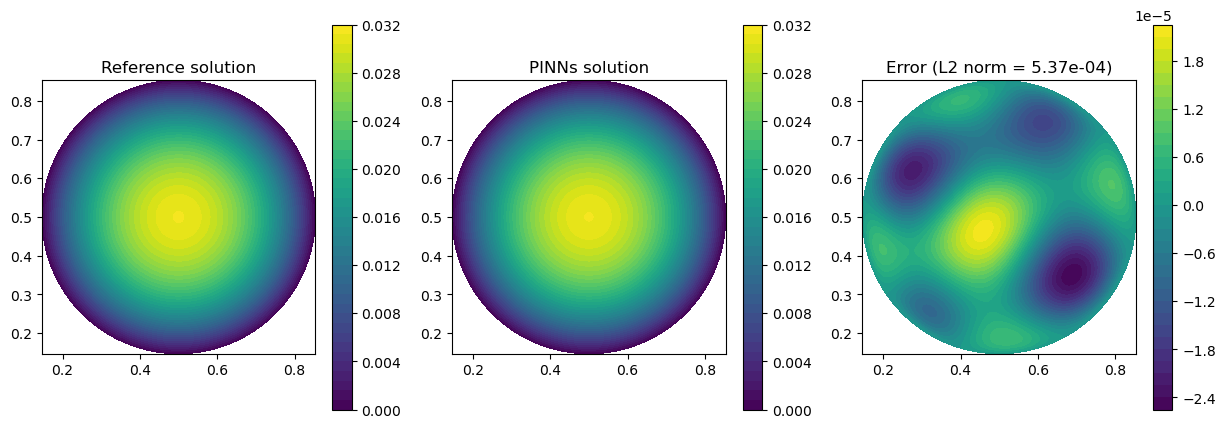

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
c = df.plot(u_ref,title='Reference solution')
plt.colorbar(c)

plt.subplot(1,3,2)
c = df.plot(u_pinns,title='PINNs solution')
plt.colorbar(c)

plt.subplot(1,3,3)
c = df.plot(error,title='Error (L2 norm = {:.2e})'.format(norm_L2_PINNs))
plt.colorbar(c)

plt.show()

## Solution sur-raffinée

In [13]:
def get_u_ref(V_ref, dx_ref):
    g = df.Constant("0.0")
    bc = df.DirichletBC(V_ref, g, "on_boundary")
    f_expr = df.Constant("1.0")

    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)

    # Resolution of the variationnal problem
    a = df.inner(df.grad(u), df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    A = df.assemble(a)
    L = df.assemble(l)
    bc.apply(A, L)

    sol = df.Function(V_ref)
    df.solve(A,sol.vector(),L)

    return sol

In [14]:
u_ref = get_u_ref(V_ref, dx_ref)

pred = u_theta.setup_w_dict(X_test, mu_test)
pred = pred["w"][:,0].cpu().detach().numpy()
u_pinns = df.Function(V_ref)
u_pinns.vector()[:] = pred.copy()

error = df.Function(V_ref)
error.vector()[:] = u_ref.vector().copy()[:] - u_pinns.vector().copy()[:]
norm_L2_PINNs = (df.assemble((((u_ref - u_pinns)) ** 2) * dx_ref) ** (0.5)) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))
    

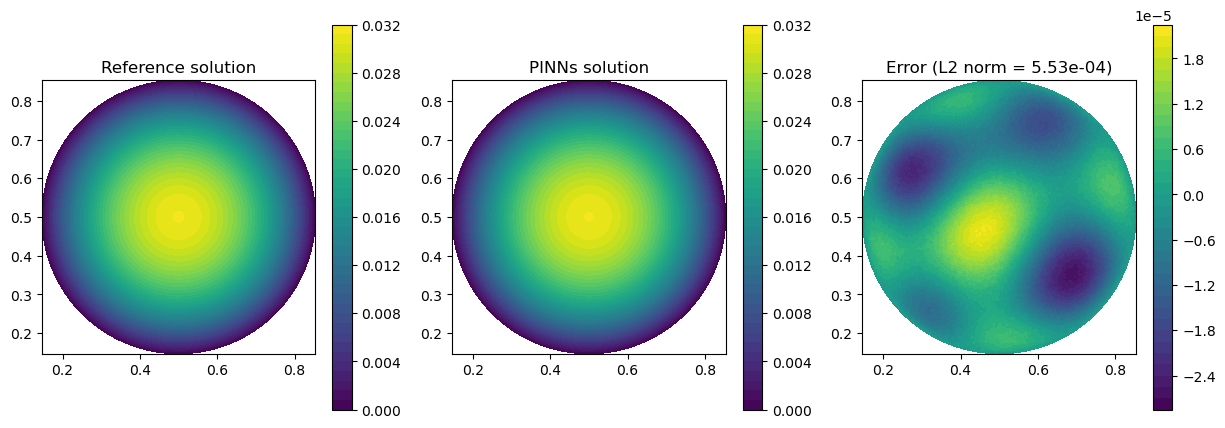

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
c = df.plot(u_ref,title='Reference solution')
plt.colorbar(c)

plt.subplot(1,3,2)
c = df.plot(u_pinns,title='PINNs solution')
plt.colorbar(c)

plt.subplot(1,3,3)
c = df.plot(error,title='Error (L2 norm = {:.2e})'.format(norm_L2_PINNs))
plt.colorbar(c)

plt.show()